In [1]:
import copy
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm


In [2]:
def readExcel(path: str, sheet_name: str, index: pd.DataFrame | None) -> pd.DataFrame:
    df = pd.read_excel(path, sheet_name, parse_dates=[0]).set_index("Date")
    df.interpolate(method="linear", limit_direction="forward", axis=0, inplace=True)
    return pd.concat([df, index], axis=1, join="outer").dropna()


In [3]:
def getMarketIndex(path: str, scope: str) -> pd.DataFrame:
    index1 = pd.read_excel(path, "HSI", parse_dates=[0]).set_index("Date").drop(columns="Volume").rename(columns={scope: "HSI"})["HSI"]
    index2 = pd.read_excel(path, "DJI", parse_dates=[0]).set_index("Date").drop(columns="Volume").rename(columns={scope: "DJI"})["DJI"]
    index3 = pd.read_excel(path, "SSEC", parse_dates=[0]).set_index("Date").drop(columns="Volume").rename(columns={scope: "SSEC"})["SSEC"]
    index = pd.concat([index1, index2, index3], axis=1, join="outer")
    return index.interpolate(method="linear", limit_direction="forward", axis=0)


In [4]:
def trainTestSplit(df: pd.DataFrame, endDate: dt.datetime) -> tuple[pd.DataFrame, pd.DataFrame]:
    trainSet = df[df.index.date <= endDate]
    testSet = df[df.index.date > endDate]
    return (trainSet, testSet)


In [5]:
def getARIMAmodel(varY: pd.Series, varX: pd.DataFrame | None, trace: bool) -> pm.ARIMA:
    return pm.auto_arima(varY, X=varX, trace=trace, m=1, seasonal=False, max_p=5, max_q=5, max_order=10, stepwise=False, n_jobs=-1)


In [6]:
def getSARIMAmodel(varY: pd.Series, varX: pd.DataFrame | None, trace: bool) -> pm.ARIMA:
    return pm.auto_arima(varY, X=varX, trace=trace, seasonal=True, m=12, d=None, D=1, max_p=5, max_q=5, start_P=0)


In [7]:
def plotPred(FC: np.ndarray, CI, index: pd.Index, fullSet: pd.DataFrame, title: str | None = None):
    Prdf = pd.Series(FC, index=index)
    PrCIdf = pd.DataFrame(CI)

    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    ax.plot(fullSet)
    ax.plot(Prdf)
    plt.xlim(xmin=dt.datetime(2022, 1, 1), xmax=dt.datetime(2023, 3, 31))
    ax.fill_between(Prdf.index, PrCIdf[0], PrCIdf[1], color='grey', alpha=.3)
    if title is not None:
        plt.title(title)


In [8]:
def plotPredFC(PredFC: np.ndarray, PredCI, PredIndex: pd.Index, RealFC: np.ndarray, RealCI, FCIndex: pd.Index, fullSet: pd.Series, title: str | None = None):
    Prdf = pd.Series(PredFC, index=PredIndex)
    PrCIdf = pd.DataFrame(PredCI)
    FCdf = pd.Series(RealFC, index=FCIndex)
    FCCIdf = pd.DataFrame(RealCI)

    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    ax.plot(fullSet)
    ax.plot(Prdf)
    ax.plot(FCdf)
    plt.xlim(xmin=dt.datetime(2022, 1, 1), xmax=dt.datetime(2023, 3, 31))
    ax.fill_between(Prdf.index, PrCIdf[0], PrCIdf[1], color='grey', alpha=.3)
    ax.fill_between(FCdf.index, FCCIdf[0], FCCIdf[1], color='grey', alpha=.3)
    if title is not None:
        plt.title(title)


In [9]:
def getMAPE(pred: pd.Series | np.ndarray, true: pd.Series) -> float:
    return np.mean(np.abs(pred - true) / np.abs(true))


In [10]:
def getRequiredTimestamp(index: list) -> list:
    febHolidays = [4, 5, 11, 12, 18, 19, 25, 26]
    marHolidays = [4, 5, 11, 12, 18, 19, 25, 26]

    for month in range(1, 4):
        for day in range(1, 32):
            if month == 2 and day <= 28 and (day > 21 and day not in febHolidays):
                index.append(pd.Timestamp(2023, month, day))
            elif month == 3 and day <= 31 and (day not in marHolidays):
                index.append(pd.Timestamp(2023, month, day))
    return index


In [11]:
path = "./Ex4_data2.xlsx"
scope = "Adj Close"
endDate = dt.date(2022, 12, 31)

index = getMarketIndex(path, scope)
HK0005 = readExcel(path, "0005.HK", index)
HK0027 = readExcel(path, "0027.HK", index)
HK0101 = readExcel(path, "0101.HK", index)
HK0005Train, HK0005Test = trainTestSplit(HK0005, endDate)
HK0027Train, HK0027Test = trainTestSplit(HK0027, endDate)
HK0101Train, HK0101Test = trainTestSplit(HK0101, endDate)


### Basic ARIMA


#### 0005HK


In [12]:
# HK0005Base = getARIMAmodel(HK0005Train[scope], True) # SARIMAX(3, 1, 2)
HK0005Base = pm.ARIMA(order=(3, 1, 2), suppress_warnings=True).fit(HK0005Train[scope])
HK0005Base.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5749
Model:               SARIMAX(3, 1, 2)   Log Likelihood               -6406.371
Date:                Tue, 07 Mar 2023   AIC                          12826.741
Time:                        15:13:58   BIC                          12873.337
Sample:                             0   HQIC                         12842.958
                               - 5749                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    1.88e-05      0.009      0.002      0.998      -0.017       0.017
ar.L1          1.1028      0.009    123.085      0.000       1.085       1.120
ar.L2         -0.9680      0.009   -102.131      0.000      -0.987      -0.949
ar.L3         -0.0191      0.007     -2.929      0.003      -0.032      -0.006
ma.L1         -1.1138      0.007   -168.422      0.000      -1.127      -1.101
ma.L2          0.9819      0.007    146.633      0.000       0.969       0.995
sigma2         0.5444      0.004    128.277      0.000       0.536       0.553
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             28891.04
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                            -0.37
Prob(H) (two-sided):                  0.02   Kurtosis:                        13.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
HK0005BFC, HK0005BCI = HK0005Base.predict(n_periods=len(HK0005Test[scope]), return_conf_int=True)
HK0005BMAPE = getMAPE(HK0005BFC, HK0005Test[scope])

# plotPred(HK0005BFC, HK0005BCI, HK0005Test.index, HK0005[scope])
print(f"MAPE: {HK0005BMAPE}")


MAPE: 0.13199783875148693


#### 0027HK


In [14]:
# HK0027Base = getARIMAmodel(HK0027Train[scope], True) # SARIMAX(4, 1, 4)
HK0027Base = pm.ARIMA(order=(4, 1, 4), suppress_warnings=True).fit(HK0027Train[scope])
HK0027Base.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5749
Model:               SARIMAX(4, 1, 4)   Log Likelihood               -6746.785
Date:                Tue, 07 Mar 2023   AIC                          13513.570
Time:                        15:14:04   BIC                          13580.136
Sample:                             0   HQIC                         13536.737
                               - 5749                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0095      0.011      0.869      0.385      -0.012       0.031
ar.L1          0.6176      0.030     20.450      0.000       0.558       0.677
ar.L2         -0.3519      0.040     -8.846      0.000      -0.430      -0.274
ar.L3          0.5191      0.038     13.574      0.000       0.444       0.594
ar.L4         -0.8728      0.027    -31.794      0.000      -0.927      -0.819
ma.L1         -0.5970      0.030    -20.230      0.000      -0.655      -0.539
ma.L2          0.3185      0.037      8.588      0.000       0.246       0.391
ma.L3         -0.5338      0.035    -15.097      0.000      -0.603      -0.464
ma.L4          0.8705      0.026     33.615      0.000       0.820       0.921
sigma2         0.6123      0.005    134.515      0.000       0.603       0.621
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):             29430.58
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):              69.60   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
HK0027BFC, HK0027BCI = HK0027Base.predict(n_periods=len(HK0027Test[scope]), return_conf_int=True)
HK0027BMAPE = getMAPE(HK0027BFC, HK0027Test[scope])

# plotPred(HK0027BFC, HK0027BCI, HK0027Test.index, HK0027[scope])
print(f"MAPE: {HK0027BMAPE}")


MAPE: 0.03943919532206402


#### 0101HK


In [16]:
# HK0101Base = getARIMAmodel(HK0101Train[scope], True) # SARIMAX(1, 1, 1)
HK0101Base = pm.ARIMA(order=(1, 1, 1), suppress_warnings=True).fit(HK0101Train[scope])
HK0101Base.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5749
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -924.512
Date:                Tue, 07 Mar 2023   AIC                           1857.024
Time:                        15:14:06   BIC                           1883.651
Sample:                             0   HQIC                          1866.291
                               - 5749                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.000      0.701      0.483      -0.000       0.001
ar.L1          0.9108      0.032     28.599      0.000       0.848       0.973
ma.L1         -0.9294      0.029    -32.579      0.000      -0.985      -0.873
sigma2         0.0808      0.001     96.876      0.000       0.079       0.082
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):              5006.50
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               4.12   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
HK0101BFC, HK0101BCI = HK0101Base.predict(n_periods=len(HK0101Test[scope]), return_conf_int=True)
HK0101BMAPE = getMAPE(HK0101BFC, HK0101Test[scope])

# plotPred(HK0101BFC, HK0101BCI, HK0101Test.index, HK0101[scope])
print(f"MAPE: {HK0101BMAPE}")


MAPE: 0.03181780337103085


### ARIMA


#### 0005HK


In [18]:
# HK0005ARIMA = getARIMAmodel(HK0005Train[scope], HK0005Train[["HSI", "DJI", "SSEC"]], True) # SARIMAX(0, 1, 0)
HK0005ARIMA = pm.ARIMA(order=(0, 1, 0), suppress_warnings=True).fit(HK0005Train[scope], HK0005Train[["HSI", "DJI", "SSEC"]])
HK0005ARIMA.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5749
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4431.030
Date:                Tue, 07 Mar 2023   AIC                           8872.061
Time:                        15:14:07   BIC                           8905.344
Sample:                             0   HQIC                          8883.644
                               - 5749                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0013      0.007     -0.188      0.851      -0.015       0.012
HSI            0.0019   1.62e-05    116.450      0.000       0.002       0.002
DJI         6.177e-05   2.66e-05      2.323      0.020    9.64e-06       0.000
SSEC          -0.0015      0.000    -10.113      0.000      -0.002      -0.001
sigma2         0.2736      0.002    134.565      0.000       0.270       0.278
===================================================================================
Ljung-Box (L1) (Q):                   1.16   Jarque-Bera (JB):             39227.76
Prob(Q):                              0.28   Prob(JB):                         0.00
Heteroskedasticity (H):               1.37   Skew:                            -0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
HK0005AFC, HK0005ACI = HK0005ARIMA.predict(n_periods=len(HK0005Test[scope]), X=HK0005Test[["HSI", "DJI", "SSEC"]], return_conf_int=True)
HK0005AMAPE = getMAPE(HK0005AFC, HK0005Test[scope])

# plotPred(HK0005AFC, HK0005ACI, HK0005Test.index, HK0005[scope])
print(f"MAPE: {HK0005AMAPE}")


MAPE: 0.08234194242855716


/home/alex/miniconda3/envs/nppd/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


#### 0027HK


In [20]:
# HK0027ARIMA = getARIMAmodel(HK0027Train[scope], HK0027Train[["HSI", "DJI", "SSEC"]], True) # SARIMAX(4, 1, 4)
HK0027ARIMA = pm.ARIMA(order=(4, 1, 4), suppress_warnings=True).fit(HK0027Train[scope], HK0027Train[["HSI", "DJI", "SSEC"]])
HK0027ARIMA.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5749
Model:               SARIMAX(4, 1, 4)   Log Likelihood               -6103.598
Date:                Tue, 07 Mar 2023   AIC                          12233.197
Time:                        15:14:10   BIC                          12319.733
Sample:                             0   HQIC                         12263.313
                               - 5749                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0080      0.008      1.042      0.297      -0.007       0.023
HSI            0.0012   2.65e-05     45.050      0.000       0.001       0.001
DJI            0.0002   3.09e-05      5.598      0.000       0.000       0.000
SSEC          -0.0002      0.000     -0.847      0.397      -0.001       0.000
ar.L1          0.7244      0.108      6.713      0.000       0.513       0.936
ar.L2         -0.7413      0.121     -6.138      0.000      -0.978      -0.505
ar.L3          0.7407      0.087      8.526      0.000       0.570       0.911
ar.L4         -0.6010      0.069     -8.707      0.000      -0.736      -0.466
ma.L1         -0.7101      0.109     -6.513      0.000      -0.924      -0.496
ma.L2          0.6910      0.119      5.828      0.000       0.459       0.923
ma.L3         -0.7505      0.085     -8.841      0.000      -0.917      -0.584
ma.L4          0.5739      0.072      8.006      0.000       0.433       0.714
sigma2         0.4905      0.004    121.272      0.000       0.483       0.498
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             31071.93
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):              15.65   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
HK0027AFC, HK0027ACI = HK0027ARIMA.predict(n_periods=len(HK0027Test[scope]), X=HK0027Test[["HSI", "DJI", "SSEC"]], return_conf_int=True)
HK0027AMAPE = getMAPE(HK0027AFC, HK0027Test[scope])

# plotPred(HK0027AFC, HK0027ACI, HK0027Test.index, HK0027[scope])
print(f"MAPE: {HK0027AMAPE}")


MAPE: 0.013883391284935067


/home/alex/miniconda3/envs/nppd/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


#### 0101HK


In [22]:
# HK0101ARIMA = getARIMAmodel(HK0101Train[scope], HK0101Train[["HSI", "DJI", "SSEC"]], True) # SARIMAX(4, 1, 4)
HK0101ARIMA = pm.ARIMA(order=(4, 1, 4), suppress_warnings=True).fit(HK0101Train[scope], HK0101Train[["HSI", "DJI", "SSEC"]])
HK0101ARIMA.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5749
Model:               SARIMAX(4, 1, 4)   Log Likelihood                 477.788
Date:                Tue, 07 Mar 2023   AIC                           -929.577
Time:                        15:14:15   BIC                           -843.041
Sample:                             0   HQIC                          -899.461
                               - 5749                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.000      1.019      0.308      -0.000       0.001
HSI            0.0006   8.01e-06     73.551      0.000       0.001       0.001
DJI        -9.422e-06   1.33e-05     -0.710      0.478   -3.54e-05    1.66e-05
SSEC           0.0002   5.86e-05      3.830      0.000       0.000       0.000
ar.L1         -0.0124      0.377     -0.033      0.974      -0.752       0.727
ar.L2          0.5067      0.358      1.416      0.157      -0.195       1.208
ar.L3          0.2756      0.423      0.651      0.515      -0.554       1.105
ar.L4          0.1109      0.226      0.491      0.624      -0.332       0.554
ma.L1         -0.0579      0.377     -0.153      0.878      -0.797       0.682
ma.L2         -0.5484      0.375     -1.464      0.143      -1.283       0.186
ma.L3         -0.2533      0.438     -0.578      0.563      -1.112       0.606
ma.L4         -0.0768      0.244     -0.315      0.753      -0.555       0.401
sigma2         0.0497      0.001     92.011      0.000       0.049       0.051
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4471.08
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               3.01   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
HK0101AFC, HK0101ACI = HK0101ARIMA.predict(n_periods=len(HK0101Test[scope]), X=HK0101Test[["HSI", "DJI", "SSEC"]], return_conf_int=True)
HK0101AMAPE = getMAPE(HK0101AFC, HK0101Test[scope])

# plotPred(HK0101AFC, HK0101ACI, HK0101Test.index, HK0101[scope])
print(f"MAPE: {HK0101AMAPE}")


MAPE: 0.05127126885550437


/home/alex/miniconda3/envs/nppd/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### SARIMA


#### 0005HK


In [24]:
# HK0005SARIMA = getSARIMAmodel(HK0005Train[scope], HK0005Train[["HSI", "DJI", "SSEC"]], True) # SARIMAX(1, 0, 0)x(1, 1, [1], 12)
HK0005SARIMA = pm.ARIMA(order=(1, 0, 0), seasonal_order=(1, 1, 1, 12), suppress_warnings=True).fit(HK0005Train[scope], HK0005Train[["HSI", "DJI", "SSEC"]])
HK0005SARIMA.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                 5749
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 12)   Log Likelihood               -5062.256
Date:                              Tue, 07 Mar 2023   AIC                          10140.512
Time:                                      15:15:05   BIC                          10193.750
Sample:                                           0   HQIC                         10159.042
                                             - 5749                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0177      0.002      8.813      0.000       0.014       0.022
HSI            0.0019   1.63e-05    117.929      0.000       0.002       0.002
DJI         8.949e-05   2.61e-05      3.435      0.001    3.84e-05       0.000
SSEC          -0.0020      0.000    -14.689      0.000      -0.002      -0.002
ar.L1          0.9341      0.002    515.765      0.000       0.931       0.938
ar.S.L12      -0.0965      0.010     -9.241      0.000      -0.117      -0.076
ma.S.L12      -0.7329      0.008    -90.260      0.000      -0.749      -0.717
sigma2         0.3052      0.003    121.567      0.000       0.300       0.310
===================================================================================
Ljung-Box (L1) (Q):                  92.95   Jarque-Bera (JB):             26539.85
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.41   Skew:                            -0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
HK0005SFC, HK0005SCI = HK0005SARIMA.predict(n_periods=len(HK0005Test[scope]), X=HK0005Test[["HSI", "DJI", "SSEC"]], return_conf_int=True)
HK0005SMAPE = getMAPE(HK0005SFC, HK0005Test[scope])

# plotPred(HK0005SFC, HK0005SCI, HK0005Test.index, HK0005[scope])
print(f"MAPE: {HK0005SMAPE}")


MAPE: 0.07463882272121612


/home/alex/miniconda3/envs/nppd/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


#### 0027HK


In [26]:
# HK0027SARIMA = getSARIMAmodel(HK0027Train[scope], HK0027Train[["HSI", "DJI", "SSEC"]], True) # SARIMAX(2, 0, 2)x(1, 1, 2, 12)
HK0027SARIMA = pm.ARIMA(order=(2, 0, 2), seasonal_order=(1, 1, 2, 12), suppress_warnings=True).fit(HK0027Train[scope], HK0027Train[["HSI", "DJI", "SSEC"]])
HK0027SARIMA.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 5749
Model:             SARIMAX(2, 0, 2)x(1, 1, 2, 12)   Log Likelihood               -6576.350
Date:                            Tue, 07 Mar 2023   AIC                          13176.700
Time:                                    15:16:42   BIC                          13256.557
Sample:                                         0   HQIC                         13204.495
                                           - 5749                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0109      0.004     -2.972      0.003      -0.018      -0.004
HSI            0.0012   2.77e-05     44.445      0.000       0.001       0.001
DJI            0.0002   3.23e-05      7.005      0.000       0.000       0.000
SSEC          -0.0008      0.000     -3.890      0.000      -0.001      -0.000
ar.L1          0.7607      0.062     12.343      0.000       0.640       0.882
ar.L2          0.1602      0.058      2.747      0.006       0.046       0.275
ma.L1          0.2630      0.060      4.408      0.000       0.146       0.380
ma.L2          0.1472      0.009     16.106      0.000       0.129       0.165
ar.S.L12      -0.4788      0.205     -2.339      0.019      -0.880      -0.078
ma.S.L12      -0.3468      0.202     -1.716      0.086      -0.743       0.049
ma.S.L24      -0.4355      0.170     -2.555      0.011      -0.770      -0.101
sigma2         0.5562      0.005    112.808      0.000       0.547       0.566
===================================================================================
Ljung-Box (L1) (Q):                   9.72   Jarque-Bera (JB):             24331.03
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              14.53   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
HK0027SFC, HK0027SCI = HK0027SARIMA.predict(n_periods=len(HK0027Test[scope]), X=HK0027Test[["HSI", "DJI", "SSEC"]], return_conf_int=True)
HK0027SMAPE = getMAPE(HK0027SFC, HK0027Test[scope])

# plotPred(HK0027SFC, HK0027SCI, HK0027Test.index, HK0027[scope])
print(f"MAPE: {HK0027SMAPE}")


MAPE: 0.0569654529715583


/home/alex/miniconda3/envs/nppd/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


#### 0101HK


In [28]:
# HK0101SARIMA = getSARIMAmodel(HK0101Train[scope], HK0101Train[["HSI", "DJI", "SSEC"]], True) # SARIMAX(1, 0, 1)x(2, 1, [1, 2], 12)
HK0101SARIMA = pm.ARIMA(order=(1, 0, 1), seasonal_order=(2, 1, 2, 12), suppress_warnings=True).fit(HK0101Train[scope], HK0101Train[["HSI", "DJI", "SSEC"]])
HK0101SARIMA.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                 5749
Model:             SARIMAX(1, 0, 1)x(2, 1, [1, 2], 12)   Log Likelihood                -180.083
Date:                                 Tue, 07 Mar 2023   AIC                            382.167
Time:                                         15:18:04   BIC                            455.369
Sample:                                              0   HQIC                           407.645
                                                - 5749                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0096      0.002     -4.189      0.000      -0.014      -0.005
HSI            0.0007   8.05e-06     80.867      0.000       0.001       0.001
DJI         -1.79e-05   1.28e-05     -1.402      0.161   -4.29e-05    7.12e-06
SSEC        5.261e-05   6.02e-05      0.874      0.382   -6.53e-05       0.000
ar.L1          0.8906      0.004    207.717      0.000       0.882       0.899
ma.L1          0.0112      0.012      0.964      0.335      -0.012       0.034
ar.S.L12      -0.4231      0.099     -4.288      0.000      -0.617      -0.230
ar.S.L24      -0.1845      0.019     -9.557      0.000      -0.222      -0.147
ma.S.L12      -0.3087      0.098     -3.150      0.002      -0.501      -0.117
ma.S.L24      -0.0440      0.061     -0.722      0.470      -0.163       0.075
sigma2         0.0623      0.001     75.350      0.000       0.061       0.064
===================================================================================
Ljung-Box (L1) (Q):                   9.08   Jarque-Bera (JB):              1539.83
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.83   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
HK0101SFC, HK0101SCI = HK0101SARIMA.predict(n_periods=len(HK0101Test[scope]), X=HK0101Test[["HSI", "DJI", "SSEC"]], return_conf_int=True)
HK0101SMAPE = getMAPE(HK0101SFC, HK0101Test[scope])

# plotPred(HK0101SFC, HK0101SCI, HK0101Test.index, HK0101[scope])
print(f"MAPE: {HK0101SMAPE}")


MAPE: 0.04607797239604674


/home/alex/miniconda3/envs/nppd/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### Forcasting with basic model


In [30]:
indexExt = getRequiredTimestamp(list(copy.deepcopy(HK0005Test.index)))


#### 0005HK

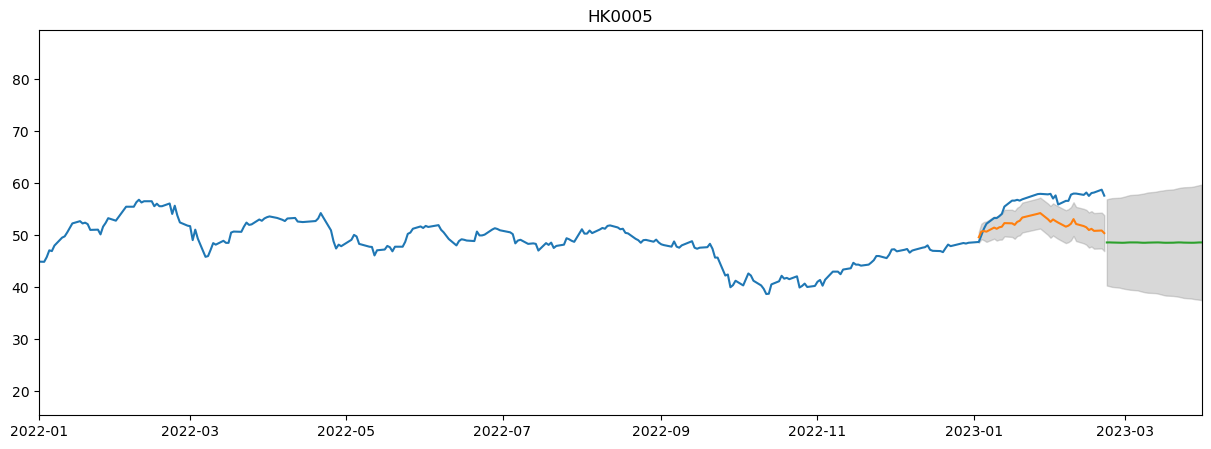

In [31]:
HK0005FFC, HK0005FCI = HK0005Base.predict(n_periods=len(indexExt), return_conf_int=True)
plotPredFC(HK0005SFC, HK0005SCI, HK0005Test.index, HK0005FFC[33:], HK0005FCI[33:], indexExt[33:], HK0005[scope], "HK0005")


In [32]:
[(indexExt[x], HK0005FFC[x]) for x in [46, 48, 50]]


[(Timestamp('2023-03-13 00:00:00'), 48.606933269598066),
 (Timestamp('2023-03-15 00:00:00'), 48.59425742623947),
 (Timestamp('2023-03-17 00:00:00'), 48.548029888317906)]

#### 0027HK

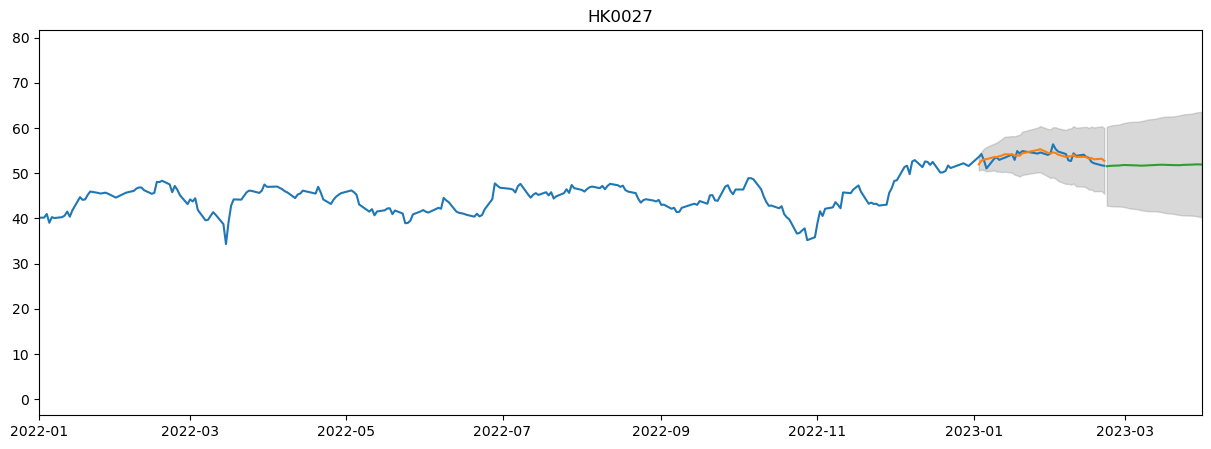

In [33]:
HK0027FFC, HK0027FCI = HK0027Base.predict(n_periods=len(indexExt), return_conf_int=True)
plotPredFC(HK0027AFC, HK0027ACI, HK0027Test.index, HK0027FFC[33:], HK0027FCI[33:], indexExt[33:], HK0027[scope], "HK0027")


In [34]:
[(indexExt[x], HK0027FFC[x]) for x in [46, 48, 50]]


[(Timestamp('2023-03-13 00:00:00'), 51.820418433262894),
 (Timestamp('2023-03-15 00:00:00'), 51.878101232089406),
 (Timestamp('2023-03-17 00:00:00'), 51.84688799067937)]

#### 0101HK

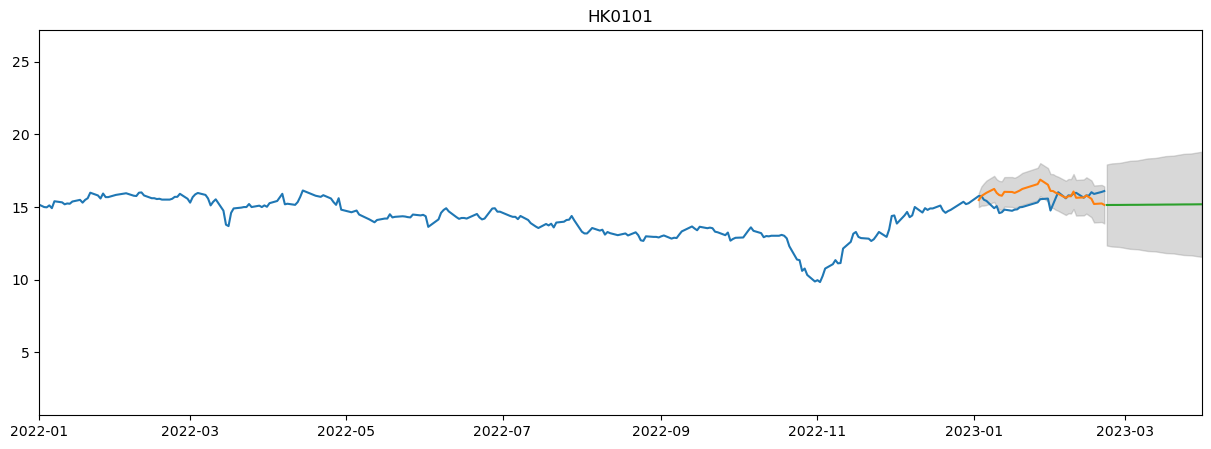

In [35]:
HK0101FFC, HK0101FCI = HK0101Base.predict(n_periods=len(indexExt), return_conf_int=True)
plotPredFC(HK0101SFC, HK0101SCI, HK0101Test.index, HK0101FFC[33:], HK0101FCI[33:], indexExt[33:], HK0101[scope], "HK0101")


In [36]:
[(indexExt[x], HK0101FFC[x]) for x in [46, 48, 50]]


[(Timestamp('2023-03-13 00:00:00'), 15.16044811506232),
 (Timestamp('2023-03-15 00:00:00'), 15.16427981760402),
 (Timestamp('2023-03-17 00:00:00'), 15.168184298179733)]